In [6]:


!pip install -q gymnasium[box2d] imageio imageio-ffmpeg==0.4.7


import importlib, sys
try:
    import gymnasium
    import Box2D
    print("gymnasium and Box2D available")
except Exception as e:
    print("Fallback: attempt swig + box2d-py install (may take a bit)...")
    !apt-get -qq update && apt-get -qq install -y swig
    !pip install -q box2d-py
    !pip install -q gymnasium[box2d]
    try:
        import gymnasium
        print("Installed gymnasium and box2d-py")
    except Exception as e2:
        print("Warning: still having trouble installing Box2D. See error below:")
        print(e2)


gymnasium and Box2D available


Episode 1 reward: -307.23
Episode 2 reward: -164.61
Episode 3 reward: -156.58
Episode 4 reward: -172.51
Episode 5 reward: -187.69
Avg reward: -197.72151688308412
Displaying recorded GIF (first episode):


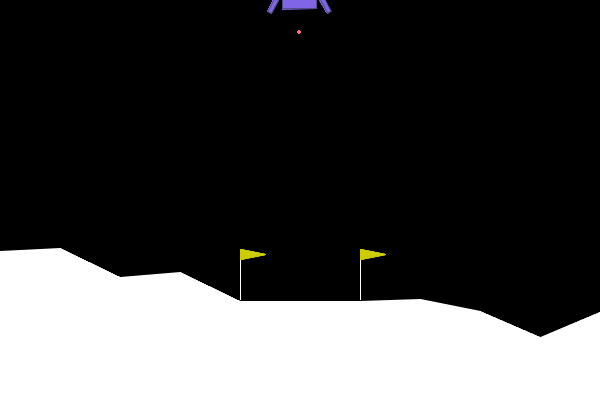

In [8]:
import gymnasium as gym
import numpy as np
import imageio
from IPython.display import Image, display
import os

def heuristic_action(obs):
    x, y, vx, vy, angle, ang_vel, left_contact, right_contact = obs

    if left_contact or right_contact:
        return 0



    angle_threshold = 0.04
    ang_vel_threshold = 0.03
    horizontal_v_threshold = 0.2
    main_engine_v_threshold = -0.2
    altitude_for_burn = 0.5


    ang_correction = angle + 0.8 * ang_vel

    if abs(ang_correction) > angle_threshold:
        if ang_correction > 0:
            return 3
        else:
            return 1


    if abs(x) > 0.2:

        if x > 0 and vx > 0:
            return 3
        if x < 0 and vx < 0:
            return 1


    if vy < main_engine_v_threshold or (y > altitude_for_burn and vy < 0.1):
        return 2


    return 0

def run_episode_and_record(env, max_steps=1000, save_gif_path=None):
    frames = []
    obs, info = env.reset()
    total_reward = 0.0
    terminated = False
    truncated = False
    step = 0
    while not (terminated or truncated) and step < max_steps:
        action = heuristic_action(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        frame = env.render()
        if isinstance(frame, np.ndarray):
            frames.append(frame)
        step += 1
    if save_gif_path and frames:
        imageio.mimsave(save_gif_path, frames, fps=30)
    return total_reward, frames


env = gym.make("LunarLander-v3", render_mode="rgb_array")
n_episodes = 5
rewards = []
gif_path = "/tmp/lunar_heuristic.gif"

for i in range(n_episodes):
    save_gif = (i == 0)
    r, frames = run_episode_and_record(env, save_gif_path=(gif_path if save_gif else None))
    print(f"Episode {i+1} reward: {r:.2f}")
    rewards.append(r)

env.close()

print("Avg reward:", np.mean(rewards))
if os.path.exists(gif_path):
    print("Displaying recorded GIF (first episode):")
    display(Image(filename=gif_path))
else:
    print("No GIF saved. Possibly frames list was empty (render not supported?).")
